https://www.kaggle.com/competitions/digit-recognizer/data

Соревнование по распознаванию MNIST датасета

In [7]:
# Распаковка архива с датасетом
!unzip "./digit-recognizer.zip"

Archive:  ./digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!rm "./digit-recognizer.zip"

In [ ]:
!pip install -q pytorch_lightning

In [69]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, models
import matplotlib.pyplot as plt
import pytorch_lightning as pl

import pandas as pd
import numpy as np

import os

# Дополнительные импорты
from tqdm.autonotebook import tqdm
from sklearn.metrics import classification_report
import warnings

# Настройка генератора случайных числе
SEED = 42
pl.seed_everything(SEED)
# Игнорировать варнинги
warnings.filterwarnings("ignore")

# Проверяем доступность CUDA и выбираем устройство для работы
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

INFO:lightning_fabric.utilities.seed:Seed set to 42


cuda


## Работа с данными

In [19]:
# Подгружаем датасет и смотрим его формат
dataset = pd.read_csv('./train.csv')
print(dataset)

       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0       0       0       0   

       pixel8  ...  pixel774  pixel775 

In [43]:
# Подгрузка данных
class MNIST_Dataset(torch.utils.data.Dataset):

  def __init__(self,
               data,
               transform=None,  # Трансформация данных на входе
               ):

    super().__init__()

    self.data = data
    self.transform = transform

  def __len__(self):
      ''' Возвращает длинну данных'''
      return len(self.data)

  def __getitem__(self, index):
      ''' Читает строку из csv файла. Преобразовываем строку в 28x28 и получаем label, что это'''

      item = self.data.iloc[index]

      image = item[1:].values.astype(np.uint8).reshape((28, 28))
      label = item[0]

      if self.transform is not None:
          image = self.transform(image)

      return image, label

In [220]:
BATCH_SIZE = 100
VALID_SIZE = .2


transform_train = transforms.Compose([
    transforms.ToPILImage(),                        # Преобразовываем в PIL формат RGB
    transforms.ToTensor(),                          # Преобразовываем в тензор
    transforms.Normalize(mean=(0.5,), std=(0.5,))   # Нормализация
])

transform_valid = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [221]:
# Создаём объекты для train/valid
train_data = MNIST_Dataset(dataset, transform=transform_train)
valid_data = MNIST_Dataset(dataset, transform=transform_valid)

# Перемешиваем данные для получения различных индексов для обучения
len_train = len(train_data)                                 # Можно брать любой train/valid, они пока что хранят одинаковые данные
indices = list(range(len_train))
np.random.shuffle(indices)                                  # Перемешиваем данные
split = int(VALID_SIZE * len_train)                         # Получаем индекс, от и до которого делим выборку
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Создаём загрузчики разными, индексами для загрузки данных
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, sampler=valid_sampler)

print(f"Length train: {len(train_idx)}")
print(f"Length valid: {len(valid_idx)}")

print(f"Train 10: {train_idx[:10]}")
print(f"Valid 10: {valid_idx[:10]}")

Length train: 33600
Length valid: 8400
Train 10: [20516, 39070, 2755, 1004, 748, 6401, 10752, 37288, 21374, 24141]
Valid 10: [32820, 36682, 6414, 5780, 18462, 21125, 21008, 8355, 13016, 16639]


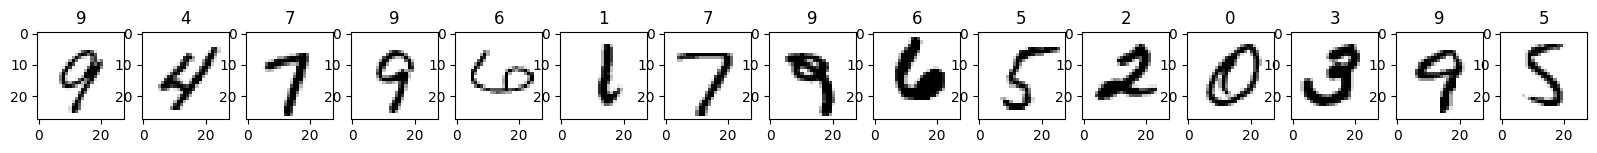

In [204]:
# Посмотрим на данные
fig, axis = plt.subplots(1, 15, figsize=(20, 10))
images, labels = next(iter(train_loader))

for i, ax in enumerate(axis.flat):
      image, label = images[i], labels[i]

      ax.imshow(image.view(28, 28), cmap='binary')
      ax.set(title = f"{label}")

## Нейросетка

In [211]:
class my_MNIST_NN(nn.Module):

  def __init__(self):
    '''Инициализация неросетки'''

    super().__init__() # Получаем доступ к методам родительского класса

    self.layer1 = nn.Sequential(

        nn.Conv2d(in_channels = 1,
                  out_channels = 32,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  padding_mode='replicate'),

        nn.ReLU(),
        nn.BatchNorm2d(32),

        nn.Conv2d(in_channels = 32,
                  out_channels = 32,
                  kernel_size=3,
                  stride=2,
                  padding=1,
                  padding_mode='replicate'),

        nn.ReLU(),
        nn.BatchNorm2d(32),

        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25)
    )


    self.layer2 = nn.Sequential(

        nn.Conv2d(in_channels = 32,
                  out_channels = 64,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  padding_mode='replicate'),

        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.Conv2d(in_channels = 64,
                  out_channels = 64,
                  kernel_size=3,
                  stride=2,
                  padding=1,
                  padding_mode='replicate'),

        nn.ReLU(),
        nn.BatchNorm2d(64),

        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25)
    )


    self.layer3 = nn.Sequential(

        nn.Conv2d(in_channels = 64,
                  out_channels = 128,
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  padding_mode='replicate'),

        nn.ReLU(),
        nn.BatchNorm2d(128),

        nn.MaxPool2d(2, 2),
        nn.Dropout(0.25)
    )

    self.final_layer = nn.Sequential(
          nn.Linear(128, 10)
    )


  def forward(self, x):
    '''Слои сетки'''

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = x.view(x.size(0), -1) # Выравниваем в одномерный тензор

    x = self.final_layer(x)

    return x

mnist_model = my_MNIST_NN()
print(mnist_model)

my_MNIST_NN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=replicate)
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=replicate)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), padding_mode=replicate)
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [222]:
LEARNING_RATE = 0.042

# Функция потерь
loss_function = nn.CrossEntropyLoss()

# Оптимизатор
optimizer = optim.SGD(mnist_model.parameters(), lr=LEARNING_RATE)

In [223]:
# Поместить модель и метрику на GPU
my_nn_model = mnist_model.to(DEVICE)

# Сколько эпох обучения
EPOCHS = 30

# Лосс, к которому стремимся
valid_loss_min = np.Inf

# Лосс обучения на каждый шаг
train_losses = []
# Лосс валидации на каждый шаг
valid_losses = []
# Точность
total_accuracy = []

# Длинны датасетов
train_len = len(train_loader)
valid_len = len(valid_loader)

print(f"Length train: {len(train_idx)}")
print(f"Length valid: {len(valid_idx)}")
print(f"BATCH: {BATCH_SIZE}" )
print(f"Train len: {train_len}" )
print(f"Valid len: {valid_len}" )

# Начинаем обучение для каждой эпохи
# tqdm - отслеживает выполнение
for epoch in tqdm(range(EPOCHS)):

  running_loss = 0

  # Переводим модель в режим обучения
  my_nn_model.train()

  # Для каждой части датасета
  # Один шаг обучения
  for images, labels in train_loader:

    images, labels = images.to(DEVICE), labels.to(DEVICE)

    # ОБНУЛЯЕМ градиенты у оптимизатора
    optimizer.zero_grad()

    # Пропускам данные через модель
    outputs = my_nn_model(images)

    # Считаем лосс
    loss = loss_function(outputs, labels)

    # Делаем шаг в обратном направлении
    loss.backward()

    # Собираем лоссы
    running_loss += loss.item()

    # Делаем шаг оптимизатора
    optimizer.step()

  else:

    valid_loss = 0
    accuracy = 0

    # Режим инференса или валидации, тестирования
    my_nn_model.eval()
    # Выключаем градиенты у валидации (они тут не нужны) Обязательно добавить
    with torch.no_grad():

      # Один шаг валидации
      for images, labels in valid_loader:

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Пропускаем данные, выравниваем в одномерный тензор, считаем лоссы
        outputs = my_nn_model(images)

        _, top_class = outputs.topk(1, dim=1)

        # Проверяем, что верно угадали класс
        equals = top_class == labels.view(*top_class.shape)

        # Собираем лоссы
        valid_loss += loss_function(outputs, labels)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    train_losses.append(running_loss/train_len)
    valid_losses.append(valid_loss/valid_len)
    total_accuracy.append(accuracy/valid_len)

    network_learned = valid_loss < valid_loss_min

    print(f"Epoch: {epoch}/{EPOCHS}:",
          f"Train loss: {running_loss/train_len}",
          f"Valid loss: {valid_loss/valid_len}",
          f"Accuracy: {accuracy/valid_len}")

    if network_learned:
        valid_loss_min = valid_loss
        torch.save(my_nn_model.state_dict(), 'model_mtl_mnist.pt')
        print('Save model')

Length train: 33600
Length valid: 8400
BATCH: 100
Train len: 336
Valid len: 84


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0/30: Train loss: 0.0418230336986848 Valid loss: 0.01952504925429821 Accuracy: 0.9938095808029175
Save model
Epoch: 1/30: Train loss: 0.03584618248922717 Valid loss: 0.01796313375234604 Accuracy: 0.9949998259544373
Save model
Epoch: 2/30: Train loss: 0.03382983635951643 Valid loss: 0.017997782677412033 Accuracy: 0.9941667914390564
Epoch: 3/30: Train loss: 0.02926413323265955 Valid loss: 0.01795002818107605 Accuracy: 0.9947620630264282
Save model
Epoch: 4/30: Train loss: 0.027305722647898142 Valid loss: 0.017194584012031555 Accuracy: 0.9947620630264282
Save model
Epoch: 5/30: Train loss: 0.02327868047965846 Valid loss: 0.01708175241947174 Accuracy: 0.9947619438171387
Save model
Epoch: 6/30: Train loss: 0.02408334210572537 Valid loss: 0.017416654154658318 Accuracy: 0.994404673576355
Epoch: 7/30: Train loss: 0.024310443863041223 Valid loss: 0.016598820686340332 Accuracy: 0.9948810338973999
Save model
Epoch: 8/30: Train loss: 0.02283117388461029 Valid loss: 0.017161427065730095 Accu

Первая версия сетки, очень плохая точность. Попробуем убрать softmax в конце
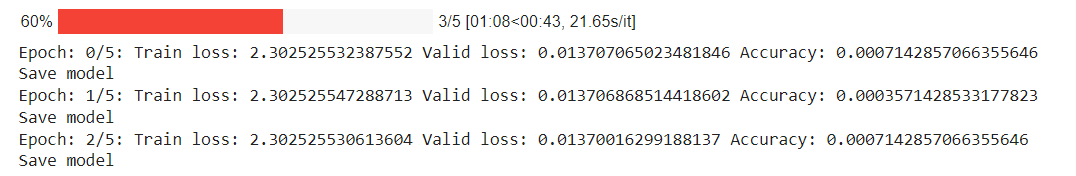

Снова очень плохая точность попробуем добавить batch нормализацию

Проблема с точностью скрывалась за тем, что неверно собирал её. Поменял, стало лучше, но всё равно как будто в 10 раз меньше, попробую увеличить на порядок точность обучения

Проблема оказалась где-то в задании выборки, когда поменял значение на 0.15 вместо 0.2 стало всё ок. Видимо, нужно больше данных для обучения

Добавим MaxPool и DropOut для лучшего обучения

## Проверка работоспособности сетки

In [243]:
# Зададим классы
classes = ['0', '1', '2', '3', '4',
           '5', '6', '7', '8', '9']

test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

my_nn_model.eval()

for data, target in valid_loader:

    data, target = data.cuda(), target.cuda()

    output = my_nn_model(data)

    loss = loss_function(output, target)

    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(target.data.view_as(pred))

    correct = np.squeeze(correct_tensor.numpy()) if not "cuda" else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(BATCH_SIZE):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(valid_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %0.4f%% (%2d/%2d)' % (
            classes[i], class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.003304

Test Accuracy of     0: 0.9940% (831/836)
Test Accuracy of     1: 0.9967% (916/919)
Test Accuracy of     2: 0.9949% (780/784)
Test Accuracy of     3: 0.9909% (874/882)
Test Accuracy of     4: 0.9938% (797/802)
Test Accuracy of     5: 0.9960% (741/744)
Test Accuracy of     6: 0.9940% (833/838)
Test Accuracy of     7: 0.9967% (897/900)
Test Accuracy of     8: 0.9940% (829/834)
Test Accuracy of     9: 0.9930% (855/861)

Test Accuracy (Overall): 99.44% (8353/8400)
